In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"piya2705","key":"b679e59b3eba27925bd034e35a9b4e94"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle  # Make sure kaggle package is installed

# Download the dataset (about 1.2 GB)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.20G/2.29G [00:20<00:02, 40.5MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s] 


In [5]:
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 - 147s - 901ms/step - accuracy: 0.7797 - loss: 0.4718 - val_accuracy: 0.8125 - val_loss: 0.4555 - learning_rate: 1.0000e-03
Epoch 2/10
163/163 - 102s - 626ms/step - accuracy: 0.8746 - loss: 0.2942 - val_accuracy: 0.8125 - val_loss: 0.4551 - learning_rate: 1.0000e-03
Epoch 3/10
163/163 - 100s - 614ms/step - accuracy: 0.8982 - loss: 0.2458 - val_accuracy: 0.8125 - val_loss: 0.4567 - learning_rate: 1.0000e-03
Epoch 4/10
163/163 - 103s - 630ms/step - accuracy: 0.9053 - loss: 0.2267 - val_accuracy: 0.8125 - val_loss: 0.4168 - learning_rate: 1.0000e-03
Epoch 5/10
163/163 - 100s - 614ms/step - accuracy: 0.9057 - loss: 0.2278 - val_accuracy: 0.8750 - val_loss: 0.3941 - learning_rate: 1.0000e-03
Epoch 6/10
163/163 - 103s - 632ms/step - accuracy: 0.9145 - loss: 0.2161 - val_accuracy: 0.8750 - val_loss: 0.3663 - learning_rate: 1.0000e-03
Epoch 7/10
163/163 - 100s - 615ms/step - accuracy: 0.9095 - loss: 0.2171 - val_accuracy: 0.7500 - val_loss: 0.4729 - learning_rate: 1.0000e-03

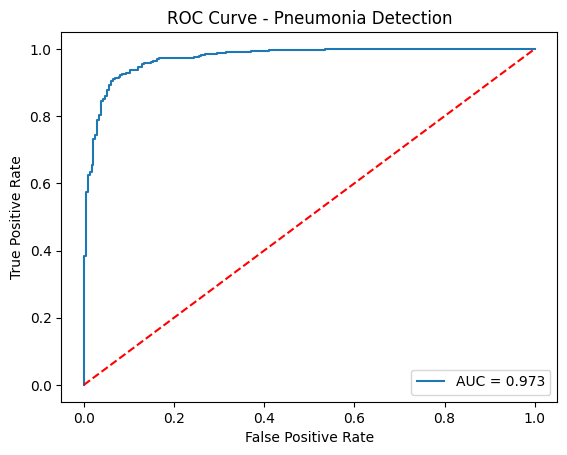

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ---------------- DIRECTORIES ----------------
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

# ---------------- DATA AUGMENTATION ----------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# ---------------- MODEL ----------------
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base for initial training

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# ---------------- CALLBACKS ----------------
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ---------------- TRAIN (HEAD ONLY) ----------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[lr_reduction, early_stop],
    verbose=2
)

# ---------------- FINE-TUNE ----------------
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[lr_reduction, early_stop],
    verbose=2
)

# ---------------- EVALUATE ----------------
y_pred_probs = model.predict(test_gen)
y_true = test_gen.classes

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Pneumonia Detection")
plt.legend()
plt.show()


In [7]:
# ---------------- FINAL ACCURACY ----------------
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print(f"\n Final Test Accuracy: {test_acc * 100:.2f}%")


20/20 - 14s - 717ms/step - accuracy: 0.9247 - loss: 0.2352

 Final Test Accuracy: 92.47%


In [8]:
import os
print(os.listdir("chest_xray"))

# List all datasets available in Kaggle environment
print(os.listdir("chest_xray/test/PNEUMONIA"))
print(os.listdir("chest_xray/test/NORMAL"))
print(os.listdir("chest_xray/train/PNEUMONIA"))
print(os.listdir("chest_xray/train/NORMAL"))


['test', '__MACOSX', 'chest_xray', 'train', 'val']
['person114_bacteria_546.jpeg', 'person127_bacteria_603.jpeg', 'person133_bacteria_633.jpeg', 'person78_bacteria_386.jpeg', 'person1632_virus_2827.jpeg', 'person1642_virus_2842.jpeg', 'person117_bacteria_557.jpeg', 'person96_bacteria_465.jpeg', 'person53_virus_107.jpeg', 'person142_bacteria_683.jpeg', 'person100_bacteria_477.jpeg', 'person121_bacteria_575.jpeg', 'person111_bacteria_533.jpeg', 'person100_bacteria_475.jpeg', 'person134_bacteria_640.jpeg', 'person161_bacteria_757.jpeg', 'person1615_virus_2801.jpeg', 'person81_bacteria_396.jpeg', 'person133_bacteria_638.jpeg', 'person88_bacteria_437.jpeg', 'person145_bacteria_696.jpeg', 'person147_bacteria_705.jpeg', 'person109_bacteria_522.jpeg', 'person1661_virus_2873.jpeg', 'person81_bacteria_397.jpeg', 'person1650_virus_2852.jpeg', 'person132_bacteria_632.jpeg', 'person124_bacteria_591.jpeg', 'person153_bacteria_726.jpeg', 'person96_bacteria_466.jpeg', 'person153_bacteria_725.jpeg', 'p

In [15]:
# --------- FUNCTION TO CREATE HEATMAP ---------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input],   # ✅ change here too (model.input, not [model.inputs])
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of the predicted class with respect to feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling to get weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to [0,1]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


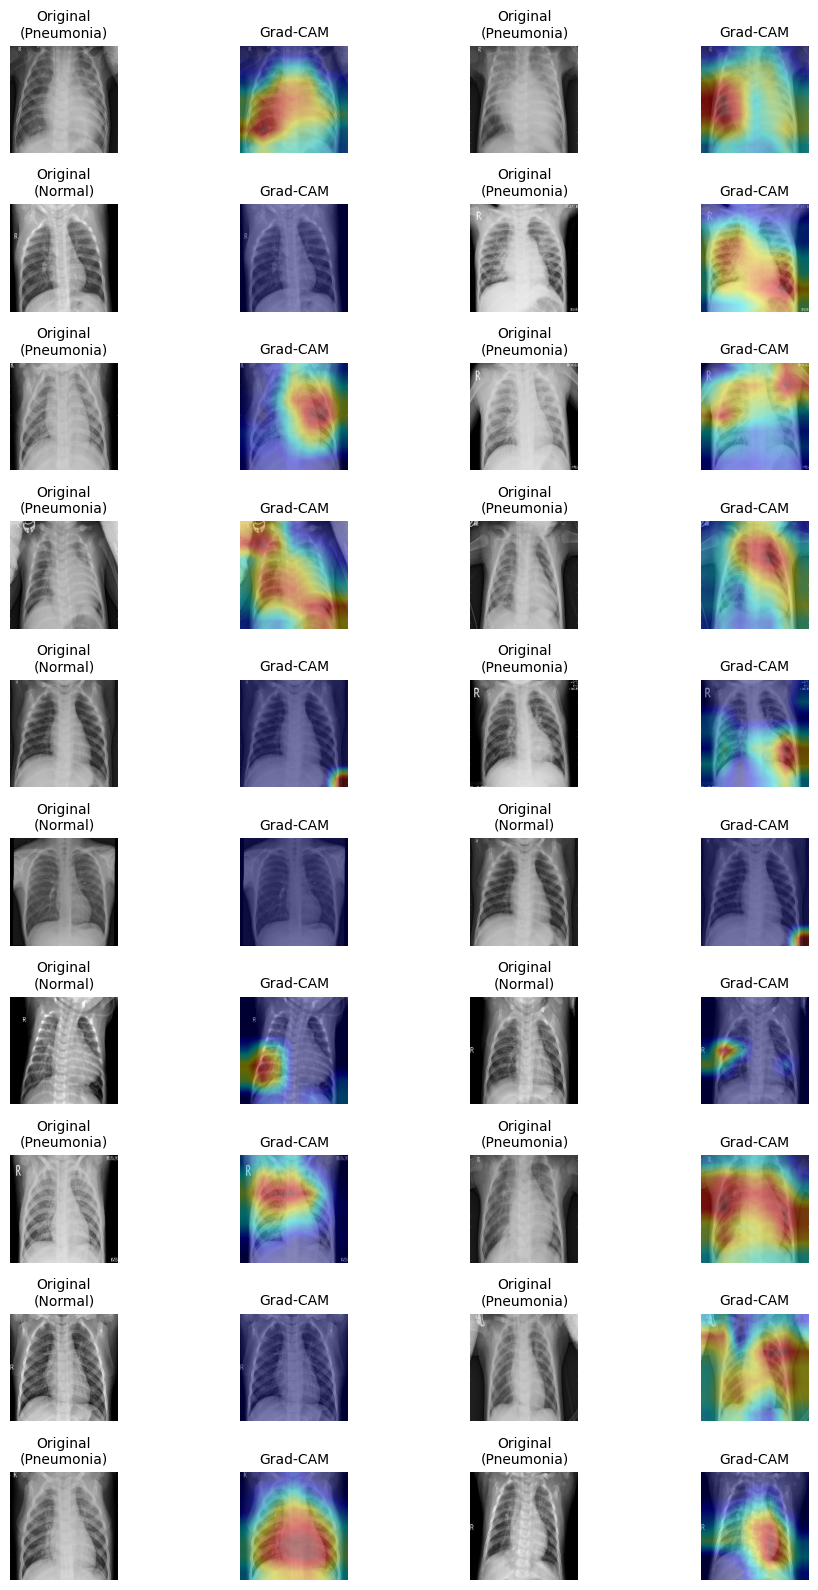

In [19]:
import random
import cv2

# --------- SHOW GRAD-CAM FOR MULTIPLE TEST IMAGES WITH LABELS ---------
def gradcam_on_random_images(model, test_gen, last_conv_layer_name="conv5_block16_concat", num_images=100, grid_size=(50,4)):
    random_indices = random.sample(range(len(test_gen.filepaths)), num_images)

    plt.figure(figsize=(10, 16))  # Adjust size depending on grid

    for i, idx in enumerate(random_indices):
        img_path = test_gen.filepaths[idx]

        # Preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Predict class
        preds = model.predict(img_array, verbose=0)
        pred_class = "Pneumonia" if preds[0][0] > 0.8 else "Normal"

        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Load original image for overlay
        original_img = cv2.imread(img_path)
        original_img = cv2.resize(original_img, (224, 224))

        # Resize heatmap to match image
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_resized = np.uint8(255 * heatmap_resized)

        # Apply color map
        heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        # Overlay on original image
        superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

        # ---- PLOT ORIGINAL ----
        plt.subplot(grid_size[0], grid_size[1], 2*i+1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original\n({pred_class})", fontsize=10)
        plt.axis("off")

        # ---- PLOT GRAD-CAM ----
        plt.subplot(grid_size[0], grid_size[1], 2*i+2)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title("Grad-CAM", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# -------- RUN FUNCTION --------
gradcam_on_random_images(model, test_gen, num_images=20, grid_size=(10,4))
